Universidad Torcuato Di Tella

Licenciatura en Tecnología Digital\
**Tecnología Digital VI: Inteligencia Artificial**


# TP3: Clasificador de imagenes


``torchvision`` contiene  data loaders para datasets conocidos como ImageNet, CIFAR10, MNIST, etc.
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

El dataset CIFAR10 contiene las siguientes clases: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
Las imagenes son de tamaño 3x32x32, i.e. imagenes de color de 3 canales (RGB) de 32x32 pixels en tamaño.


## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Cargamos los datos CIFAR10 y preparamos los sets de training, validation y test.
2. Definimos las redes. Una MLP, un una CNN
3. Definimos la loss
4. Entrenamos
5. Evaluamos en Test

### 1.Carga de datos CIFAR10


In [51]:
!pip install wandb
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.utils.data
import numpy as np
import wandb


wandb.login()


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)


cpu



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
torch.manual_seed(181988)
if torch.cuda.is_available():
    torch.cuda.manual_seed(181988)

In [53]:
#Parametros
batch_size =32
learning_rate = 0.02
momentum =.9
epochs = 10
num_classes = 10

# epochs = 20
# batch_size = 16
# learning_rate = 0.005
# weight_decay = 0.005
# momentum = 0.9

# experiment_name = "MLP"
# experiment_name = "fc_hl_bigvalues"
# experiment_name = "fc_hl_1layers"
# experiment_name = "fc_hl_values_and_2layers"
# experiment_name = "fc_hl_bigvalues_and_2layers"
# experiment_name = "fc_hl_less_values"
# experiment_name = "fc_hl_1layer_less"
# experiment_name = "fc_hl_1layerless_smallvalues"
# experiment_name = "cnn_lessvalues"
# experiment_name = "cnn_lessvalues_LR_MP"
# experiment_name = 'CNN_LeNet-5'
# experiment_name = 'CNN_ALexNet'
experiment_name = 'CNN_VGG16'
# experiment_name = 'cnn_lessvalues_resnet'


project_name = "TP3"


In [54]:
name_deep_net_exp = ['MLP','fc_hl_bigvalues','fc_hl_1layers','fc_hl_values_and_2layers','fc_hl_bigvalues_and_2layers','fc_hl_less_values','fc_hl_1layer_less','fc_hl_1layerless_smallvalues','cnn_lessvalues','cnn_lessvalues_LR_MP']
name_conv_net_exp = ['CNN_LeNet-5','CNN_ALexNet','cnn_lessvalues_resnet','CNN_VGG16']

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [55]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
targets_ = trainset.targets
train_idx, val_idx = train_test_split(np.arange(len(targets_)), test_size=0.2, stratify=targets_)
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sampler,batch_size=batch_size, num_workers=2)
valloader = torch.utils.data.DataLoader(trainset, sampler=val_sampler,batch_size=batch_size, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



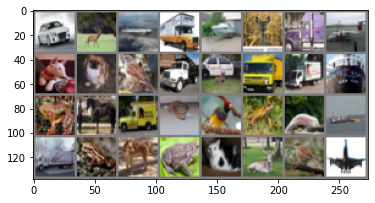

car   deer  plane truck ship  deer  truck plane dog   dog   bird  truck car   truck truck ship  frog  horse truck dog   bird  frog  bird  ship  truck frog  dog   frog  cat   deer  bird  plane


In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Definimos las redes



ARQUITECTURA

In [57]:
import torch.nn as nn
import torch.nn.functional as F

if experiment_name == "MLP":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 120)
            self.fc23 = nn.Linear(120, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x



elif experiment_name == "fc_hl_bigvalues":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 150)
            self.fc23 = nn.Linear(150, 150)
            self.fc2 = nn.Linear(150, 100)
            self.fc3 = nn.Linear(100, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x


elif experiment_name == "fc_hl_1layers":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 300)
            self.fc23 = nn.Linear(300, 200)
            self.fc_hidden = nn.Linear(200, 120)  # Nueva capa oculta con 120 nodos
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc_hidden(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

elif experiment_name == "fc_hl_bigvalues_and_2layers":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 300)
            self.fc23 = nn.Linear(300, 200)
            self.fc_hidden12 = nn.Linear(200, 200)  # Nueva capa oculta con 120 nodos
            self.fc2 = nn.Linear(200, 120)
            self.fc_hidden23 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes)

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc_hidden12(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc_hidden23(x))
            x = self.fc3(x)
            return x

elif experiment_name == "fc_hl_less_values":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 50)
            self.fc23 = nn.Linear(50, 50)
            self.fc2 = nn.Linear(50, 25)
            self.fc3 = nn.Linear(25, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

elif experiment_name == "fc_hl_1layer_less":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

elif experiment_name == "fc_hl_1layerless_smallvalues":
    class Net(nn.Module):
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(32*32*3, 32*32*3)
            self.fc21 = nn.Linear(32*32*3, 32*32)
            self.fc22 = nn.Linear(32*32, 50)
            self.fc2 = nn.Linear(50, 25)
            self.fc3 = nn.Linear(25, num_classes) # termina con 10 para quedarse con la mejor

        def forward(self, x):
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x
            

            
for i in name_deep_net_exp:
    if experiment_name == i:
        net = Net()
        net.to(device)


ARQUITECTURA CON CNN

In [58]:
if experiment_name == "cnn_lessvalues":
    class NetConv(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(in_channels = 3, x_channels = 6,kernel_size = 5, stride = 1, padding = 1)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(in_channels = 6, x_channels = 16, kernel_size = 5, stride = 1, padding = 1)
            self.fc1 = nn.Linear(16 * 5 * 5, 50)
            self.fc21 = nn.Linear(50, 50)
            self.fc22 = nn.Linear(50, 50)
            self.fc23 = nn.Linear(50, 50)
            self.fc2 = nn.Linear(50, 25)
            self.fc3 = nn.Linear(25, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = torch.flatten(x, 1) # flatten all dimensions except batch
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc21(x))
            x = F.relu(self.fc22(x))
            x = F.relu(self.fc23(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

if experiment_name == "CNN_LeNet-5":
    class NetConv(nn.Module):
        def __init__(self):
            super(NetConv, self).__init__()
            self.conv1 = nn.Conv2d(in_channels=3, x_channels=32, kernel_size=5, padding=2)
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.conv2 = nn.Conv2d(in_channels=32, x_channels=48, kernel_size=5)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.fc1 = nn.Linear(1728, 256)  # Adjusted xput size to 256
            self.fc2 = nn.Linear(256, 84)
            self.fc3 = nn.Linear(84, num_classes)

        def forward(self, x):
            x = self.pool1(F.relu(self.conv1(x)))
            x = self.pool2(F.relu(self.conv2(x)))
            x = x.view(x.size(0), -1)  # Flatten the tensor
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

# if experiment_name == "CNN_ALexNet":
#     lass NetConv(nn.Module):
#     def __init__(self, num_classes=10):
#         super(NetConv, self).__init()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
#             nn.BatchNorm2d(96),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2))
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=3, stride=2))
#         self.fc = nn.Sequential(
#             nn.Dropx(0.5),
#             nn.Linear(9216, 4096),
#             nn.ReLU())
#         self.fc1 = nn.Sequential(
#             nn.Dropx(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU())
#         self.fc2 = nn.Sequential(
#             nn.Linear(4096, num_classes))

#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)
#         x = self.layer5(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return x
class BasicBlock(nn.Module):
    expansion = 1

    def _init_(self, in_planes, planes, stride=1):
        super(BasicBlock, self)._init_()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
if experiment_name == "cnn_lessvalues_resnet":
    import torchvision.models as models
    class NetConv(nn.Module):
        def __init__(self):
            super(NetConv, self).__init__()
            self.resnet18 = models.resnet18(pretrained=True)
            num_ftrs = self.resnet18.fc.in_features
            self.resnet18.fc = nn.Linear(num_ftrs, num_classes)

        def forward(self, x):
            return self.resnet18(x)
    # Define the ResNet-18 model
    class ResNet18(nn.Module):
        def _init_(self, num_classes=10):
            super(ResNet18, self)._init_()
            self.in_planes = 64

            self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
            self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
            self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
            self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
            self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
            self.fc = nn.Linear(512, num_classes)

        def _make_layer(self, block, planes, num_blocks, stride):
            strides = [stride] + [1]*(num_blocks-1)
            layers = []
            for stride in strides:
                layers.append(block(self.in_planes, planes, stride))
                self.in_planes = planes * block.expansion
            return nn.Sequential(*layers)

        def forward(self, x):
            x = F.relu(self.bn1(self.conv1(x)))
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)
            return x


elif experiment_name == "CNN_VGG16":
    import torchvision.models as models
    # class NetConv(nn.Module):
    #     def __init__(self):
    #         super(NetConv, self).__init__()
    #         self.vgg16 = models.vgg16(pretrained=False)
    #         num_ftrs = self.vgg16.classifier[6].in_features
    #         self.vgg16.classifier[6] = nn.Linear(num_ftrs, 10)

    #     def forward(self, x):
    #         return self.vgg16(x)
# NO ANDA ESTE HAY QUE ARREGLARLO
    class NetConv(nn.Module):
        def _init_(self, num_classes=10):
            super(NetConv, self)._init_()

            self.transform = transforms.Compose(
                [
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(), 
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                ]
            )
            
            self.layer1 = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU())
            self.layer2 = nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(), 
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU())
            self.layer4 = nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer5 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU())
            self.layer6 = nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU())
            self.layer7 = nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer8 = nn.Sequential(
                nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU())
            self.layer9 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU())
            self.layer10 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer11 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU())
            self.layer12 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU())
            self.layer13 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(7*7*512, 4096),
                nn.ReLU())
            self.fc1 = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU())
            self.fc2= nn.Sequential(
                nn.Linear(4096, num_classes))
            
        def forward(self, x):
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.layer5(x)
            x = self.layer6(x)
            x = self.layer7(x)
            x = self.layer8(x)
            x = self.layer9(x)
            x = self.layer10(x)
            x = self.layer11(x)
            x = self.layer12(x)
            x = self.layer13(x)
            x = x.reshape(x.size(0), -1)
            x = self.fc(x)
            x = self.fc1(x)
            x = self.fc2(x)
            return x

for i in name_conv_net_exp:
    if experiment_name == i:
        net = NetConv()
        # net = NetConv(num_classes)
        net.to(device)

### 3. Definimos la loss y el optimizador




In [59]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay = 0.005)

ValueError: optimizer got an empty parameter list

### 4. Entrenamos

Deberiamos plotear la loss para el validation set tb!



In [ ]:
# implementar json dump para que se arme solo el archivo
wandb.init(
    # set the wandb project where this run will be logged
    project=project_name,
    name = experiment_name,
    # track hyperparameters and run metadata
    config={
        "learning_rate": learning_rate,
        "momentum": momentum,
        "batch_size": batch_size,
        "epochs": epochs,
    }
)

In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times
    # ---------------- SECCION DE TRAIN -----------------
    running_loss = 0.0
    train_correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')


        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_correct += (predicted == labels).sum().item()


    # End of test section
    # Val section
    train_accuracy = 100 * train_correct / total
    running_loss = running_loss/total

    # ---------------- SECCION DE VALIDACION ----------------
    val_correct = 0
    total =0
    val_loss =0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    # End of test section

    val_accuracy = 100 * val_correct /total
    val_loss = val_loss / total

    wandb.log({ 
        "train_accuracy": train_accuracy, 
        "val_accuracy": val_accuracy, 
        "train_loss": running_loss,
        "val_loss": val_loss})

print('Finished Training')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x512 and 25088x4096)

In [ ]:
wandb.finish()

Ejemplo de guardar el modelo. Sin embargo lo deberiamos guardar para el que mejor dio en validation.



In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)



### 5. Una vez elegido todos los hyper-parametros, evaluar el mejor modelo en Test




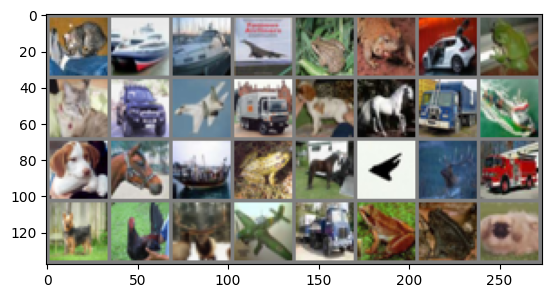

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog  


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

Cargamos el modelo (el mejor) y evaluamos en un ejemplo


In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   truck ship  ship 



Evaluamos en el set de test



In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 51 %


Algo estamos aprendiendo! Si fuese random, seria 10% accuracy (elegir random entre 10 clases).
Algunas clases se comportan peor que otras.


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 54.0 %
Accuracy for class: car   is 56.7 %
Accuracy for class: bird  is 41.1 %
Accuracy for class: cat   is 29.1 %
Accuracy for class: deer  is 49.2 %
Accuracy for class: dog   is 47.4 %
Accuracy for class: frog  is 62.7 %
Accuracy for class: horse is 56.8 %
Accuracy for class: ship  is 74.6 %
Accuracy for class: truck is 47.9 %


In [1]:
# # !pip install wandb
# import torch
# import torchvision
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import torchvision.transforms as transforms
# from sklearn.model_selection import train_test_split
# import torch.utils.data
# import numpy as np
# import wandb
# import torchvision.models as models

# wandb.login()
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# # Assuming that we are on a CUDA machine, this should print a CUDA device:
# print(device)


# torch.manual_seed(181988)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(181988)


# batch_size =32
# learning_rate = 0.02
# momentum =.9
# epochs = 10
# name_net_exp = ['CNN_LeNet-5','cnn_lessvalues_resnet']
# # name_net_exp = ['MLP','fc_hl_bigvalues','fc_hl_1layers','fc_hl_values_and_2layers','fc_hl_bigvalues_and_2layers',
# #                 'fc_hl_less_values','fc_hl_1layer_less','fc_hl_1layerless_smallvalues','cnn_lessvalues',
# #                 'CNN_LeNet-5','cnn_lessvalues_resnet']
# project_name = "TP3"


# for name in name_net_exp:
#     experiment_name = name

#     transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#     trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

#     targets_ = trainset.targets
#     train_idx, val_idx = train_test_split(np.arange(len(targets_)), test_size=0.2, stratify=targets_)
#     train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
#     val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

#     trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sampler,batch_size=batch_size, num_workers=2)
#     valloader = torch.utils.data.DataLoader(trainset, sampler=val_sampler,batch_size=batch_size, num_workers=2)

#     testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#     testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

#     classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
#     if experiment_name == "MLP":
#         class Net(nn.Module):
#             def __init__(self):
#                 super().__init__()
#                 self.fc1 = nn.Linear(32*32*3, 32*32*3)
#                 self.fc21 = nn.Linear(32*32*3, 32*32)
#                 self.fc22 = nn.Linear(32*32, 120)
#                 self.fc23 = nn.Linear(120, 120)
#                 self.fc2 = nn.Linear(120, 84)
#                 self.fc3 = nn.Linear(84, 10) # termina con 10 para quedarse con la mejor

#             def forward(self, x):
#                 x = torch.flatten(x, 1) # flatten all dimensions except batch
#                 x = F.relu(self.fc1(x))
#                 x = F.relu(self.fc21(x))
#                 x = F.relu(self.fc22(x))
#                 x = F.relu(self.fc23(x))
#                 x = F.relu(self.fc2(x))
#                 x = self.fc3(x)
#                 return x

#     elif experiment_name == "fc_hl_bigvalues":
#         class Net(nn.Module):
#             def __init__(self):
#                 super().__init__()
#                 self.fc1 = nn.Linear(32*32*3, 32*32*3)
#                 self.fc21 = nn.Linear(32*32*3, 32*32)
#                 self.fc22 = nn.Linear(32*32, 150)
#                 self.fc23 = nn.Linear(150, 150)
#                 self.fc2 = nn.Linear(150, 100)
#                 self.fc3 = nn.Linear(100, 10) # termina con 10 para quedarse con la mejor

#             def forward(self, x):
#                 x = torch.flatten(x, 1) # flatten all dimensions except batch
#                 x = F.relu(self.fc1(x))
#                 x = F.relu(self.fc21(x))
#                 x = F.relu(self.fc22(x))
#                 x = F.relu(self.fc23(x))
#                 x = F.relu(self.fc2(x))
#                 x = self.fc3(x)
#                 return x

#     elif experiment_name == "fc_hl_1layers":
#         class Net(nn.Module):
#             def __init__(self):
#                 super().__init__()
#                 self.fc1 = nn.Linear(32*32*3, 32*32*3)
#                 self.fc21 = nn.Linear(32*32*3, 32*32)
#                 self.fc22 = nn.Linear(32*32, 300)
#                 self.fc23 = nn.Linear(300, 200)
#                 self.fc_hidden = nn.Linear(200, 120)  # Nueva capa oculta con 120 nodos
#                 self.fc2 = nn.Linear(120, 84)
#                 self.fc3 = nn.Linear(84, 10)

#             def forward(self, x):
#                 x = torch.flatten(x, 1) # flatten all dimensions except batch
#                 x = F.relu(self.fc1(x))
#                 x = F.relu(self.fc21(x))
#                 x = F.relu(self.fc22(x))
#                 x = F.relu(self.fc23(x))
#                 x = F.relu(self.fc_hidden(x))
#                 x = F.relu(self.fc2(x))
#                 x = self.fc3(x)
#                 return x

#     elif experiment_name == "fc_hl_bigvalues_and_2layers":
#         class Net(nn.Module):
#             def __init__(self):
#                 super().__init__()
#                 self.fc1 = nn.Linear(32*32*3, 32*32*3)
#                 self.fc21 = nn.Linear(32*32*3, 32*32)
#                 self.fc22 = nn.Linear(32*32, 300)
#                 self.fc23 = nn.Linear(300, 200)
#                 self.fc_hidden12 = nn.Linear(200, 200)  # Nueva capa oculta con 120 nodos
#                 self.fc2 = nn.Linear(200, 120)
#                 self.fc_hidden23 = nn.Linear(120, 84)
#                 self.fc3 = nn.Linear(84, 10)

#             def forward(self, x):
#                 x = torch.flatten(x, 1) # flatten all dimensions except batch
#                 x = F.relu(self.fc1(x))
#                 x = F.relu(self.fc21(x))
#                 x = F.relu(self.fc22(x))
#                 x = F.relu(self.fc23(x))
#                 x = F.relu(self.fc_hidden12(x))
#                 x = F.relu(self.fc2(x))
#                 x = F.relu(self.fc_hidden23(x))
#                 x = self.fc3(x)
#                 return x

#     elif experiment_name == "fc_hl_less_values":
#         class Net(nn.Module):
#             def __init__(self):
#                 super().__init__()
#                 self.fc1 = nn.Linear(32*32*3, 32*32*3)
#                 self.fc21 = nn.Linear(32*32*3, 32*32)
#                 self.fc22 = nn.Linear(32*32, 50)
#                 self.fc23 = nn.Linear(50, 50)
#                 self.fc2 = nn.Linear(50, 25)
#                 self.fc3 = nn.Linear(25, 10) # termina con 10 para quedarse con la mejor

#             def forward(self, x):
#                 x = torch.flatten(x, 1) # flatten all dimensions except batch
#                 x = F.relu(self.fc1(x))
#                 x = F.relu(self.fc21(x))
#                 x = F.relu(self.fc22(x))
#                 x = F.relu(self.fc23(x))
#                 x = F.relu(self.fc2(x))
#                 x = self.fc3(x)
#                 return x

#     elif experiment_name == "fc_hl_1layer_less":
#         class Net(nn.Module):
#             def __init__(self):
#                 super().__init__()
#                 self.fc1 = nn.Linear(32*32*3, 32*32*3)
#                 self.fc21 = nn.Linear(32*32*3, 32*32)
#                 self.fc22 = nn.Linear(32*32, 120)
#                 self.fc2 = nn.Linear(120, 84)
#                 self.fc3 = nn.Linear(84, 10) # termina con 10 para quedarse con la mejor

#             def forward(self, x):
#                 x = torch.flatten(x, 1) # flatten all dimensions except batch
#                 x = F.relu(self.fc1(x))
#                 x = F.relu(self.fc21(x))
#                 x = F.relu(self.fc22(x))
#                 x = F.relu(self.fc2(x))
#                 x = self.fc3(x)
#                 return x

#     elif experiment_name == "fc_hl_1layerless_smallvalues":
#         class Net(nn.Module):
#             def __init__(self):
#                 super().__init__()
#                 self.fc1 = nn.Linear(32*32*3, 32*32*3)
#                 self.fc21 = nn.Linear(32*32*3, 32*32)
#                 self.fc22 = nn.Linear(32*32, 50)
#                 self.fc2 = nn.Linear(50, 25)
#                 self.fc3 = nn.Linear(25, 10) # termina con 10 para quedarse con la mejor

#             def forward(self, x):
#                 x = torch.flatten(x, 1) # flatten all dimensions except batch
#                 x = F.relu(self.fc1(x))
#                 x = F.relu(self.fc21(x))
#                 x = F.relu(self.fc22(x))
#                 x = F.relu(self.fc2(x))
#                 x = self.fc3(x)
#                 return x
            
#     # Convolusionales

#     elif experiment_name == "cnn_lessvalues":
#         class Net(nn.Module):
#             def __init__(self):
#                 super().__init__()
#                 self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6,kernel_size = 5, stride = 1, padding = 1)
#                 self.pool = nn.MaxPool2d(2, 2)
#                 self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 1)
#                 self.fc1 = nn.Linear(16 * 5 * 5, 50)
#                 self.fc21 = nn.Linear(50, 50)
#                 self.fc22 = nn.Linear(50, 50)
#                 self.fc23 = nn.Linear(50, 50)
#                 self.fc2 = nn.Linear(50, 25)
#                 self.fc3 = nn.Linear(25, 10)

#             def forward(self, x):
#                 x = self.pool(F.relu(self.conv1(x)))
#                 x = self.pool(F.relu(self.conv2(x)))
#                 x = torch.flatten(x, 1) # flatten all dimensions except batch
#                 x = F.relu(self.fc1(x))
#                 x = F.relu(self.fc21(x))
#                 x = F.relu(self.fc22(x))
#                 x = F.relu(self.fc23(x))
#                 x = F.relu(self.fc2(x))
#                 x = self.fc3(x)
#                 return x

#     elif experiment_name == "CNN_LeNet-5":
#         class Net(nn.Module):
#             def __init__(self):
#                 super(Net, self).__init__()
#                 self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
#                 self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#                 self.conv2 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5)
#                 self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
#                 self.fc1 = nn.Linear(1728, 256)  # Adjusted output size to 256
#                 self.fc2 = nn.Linear(256, 84)
#                 self.fc3 = nn.Linear(84, 10)

#             def forward(self, x):
#                 x = self.pool1(F.relu(self.conv1(x)))
#                 x = self.pool2(F.relu(self.conv2(x)))
#                 x = x.view(x.size(0), -1)  # Flatten the tensor
#                 x = F.relu(self.fc1(x))
#                 x = F.relu(self.fc2(x))
#                 x = self.fc3(x)
#                 return x

#     elif experiment_name == "cnn_lessvalues_resnet":
#         class Net(nn.Module):
#             def __init__(self):
#                 super(Net, self).__init__()
#                 self.resnet18 = models.resnet18(pretrained=True)
#                 num_ftrs = self.resnet18.fc.in_features
#                 self.resnet18.fc = nn.Linear(num_ftrs, 10)

#             def forward(self, x):
#                 return self.resnet18(x)
            

#     net = Net()
#     net.to(device)


#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)


#     # implementar json dump para que se arme solo el archivo
#     wandb.init(
#         # set the wandb project where this run will be logged
#         project=project_name,
#         name = experiment_name,
#         # track hyperparameters and run metadata
#         config={
#             "learning_rate": learning_rate,
#             "momentum": momentum,
#             "batch_size": batch_size,
#             "epochs": epochs,
#         }
#     )


#     for epoch in range(epochs):  # loop over the dataset multiple times

#         running_loss = 0.0
#         train_correct =0
#         total = 0
#         for i, data in enumerate(trainloader, 0):
#             # get the inputs; data is a list of [inputs, labels]
#             #inputs, labels = data
#             inputs, labels = data[0].to(device), data[1].to(device)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = net(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             # print statistics
#             running_loss += loss.item()
#             if i % 200 == 199:    # print every 200 mini-batches
#                 print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')


#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             train_correct += (predicted == labels).sum().item()


#         # End of test section
#         # Val section
#         train_accuracy = 100 * train_correct / total
#         running_loss = running_loss/total

#         val_correct = 0
#         total =0
#         val_loss =0
#         # since we're not training, we don't need to calculate the gradients for our outputs
#         with torch.no_grad():
#             for data in valloader:
#                 images, labels = data[0].to(device), data[1].to(device)
#                 # calculate outputs by running images through the network
#                 outputs = net(images)
#                 # the class with the highest energy is what we choose as prediction
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 val_correct += (predicted == labels).sum().item()
#                 val_loss += criterion(outputs, labels).item()

#         # End of test section

#         val_accuracy = 100 * val_correct /total
#         val_loss = val_loss / total

#         wandb.log({ "train_accuracy": train_accuracy, "val_accuracy": val_accuracy, "train_loss": running_loss,
#                 "val_loss": val_loss})

#     print('Finished Training')


#     wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: osaintnom (chicas_superpoderosas). Use `wandb login --relogin` to force relogin


cpu
Files already downloaded and verified
Files already downloaded and verified


[1,   200] loss: 0.210
[1,   400] loss: 0.381
[1,   600] loss: 0.536
[1,   800] loss: 0.682
[1,  1000] loss: 0.824
[1,  1200] loss: 0.953
[2,   200] loss: 0.124
[2,   400] loss: 0.243
[2,   600] loss: 0.357
[2,   800] loss: 0.472
[2,  1000] loss: 0.584
[2,  1200] loss: 0.696
[3,   200] loss: 0.095
[3,   400] loss: 0.196
[3,   600] loss: 0.295
[3,   800] loss: 0.395
[3,  1000] loss: 0.495
[3,  1200] loss: 0.593
[4,   200] loss: 0.078
[4,   400] loss: 0.161
[4,   600] loss: 0.246
[4,   800] loss: 0.332
[4,  1000] loss: 0.419
[4,  1200] loss: 0.508
[5,   200] loss: 0.068
[5,   400] loss: 0.139
[5,   600] loss: 0.213
[5,   800] loss: 0.295
[5,  1000] loss: 0.372
[5,  1200] loss: 0.453
[6,   200] loss: 0.063
[6,   400] loss: 0.125
[6,   600] loss: 0.192
[6,   800] loss: 0.261
[6,  1000] loss: 0.331
[6,  1200] loss: 0.405
[7,   200] loss: 0.055
[7,   400] loss: 0.114
[7,   600] loss: 0.174
[7,   800] loss: 0.238
[7,  1000] loss: 0.302
[7,  1200] loss: 0.370
[8,   200] loss: 0.052
[8,   400] 

train_accuracy,▁▄▅▆▆▇▇███
train_loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▅▇▇████▇▇
val_loss,█▄▁▁▂▃▄▄▇█
train_accuracy,83.2625
train_loss,0.016
val_accuracy,64.51
val_loss,0.04221


Files already downloaded and verified
Files already downloaded and verified


c:\Users\oltie\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\oltie\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[1,   200] loss: 0.290
[1,   400] loss: 0.522
[1,   600] loss: 0.726
[1,   800] loss: 0.912
[1,  1000] loss: 1.093
[1,  1200] loss: 1.262
[2,   200] loss: 0.148
[2,   400] loss: 0.289
[2,   600] loss: 0.425
[2,   800] loss: 0.554
[2,  1000] loss: 0.679
[2,  1200] loss: 0.809
[3,   200] loss: 0.134
[3,   400] loss: 0.259
[3,   600] loss: 0.376
[3,   800] loss: 0.501
[3,  1000] loss: 0.621
[3,  1200] loss: 0.744
[4,   200] loss: 0.111
[4,   400] loss: 0.222
[4,   600] loss: 0.343
[4,   800] loss: 0.477
[4,  1000] loss: 0.597
[4,  1200] loss: 0.711
[5,   200] loss: 0.103
[5,   400] loss: 0.203
[5,   600] loss: 0.301
[5,   800] loss: 0.395
[5,  1000] loss: 0.492
[5,  1200] loss: 0.593
[6,   200] loss: 0.093
[6,   400] loss: 0.185
[6,   600] loss: 0.275
[6,   800] loss: 0.362
[6,  1000] loss: 0.448
[6,  1200] loss: 0.536
[7,   200] loss: 0.090
[7,   400] loss: 0.173
[7,   600] loss: 0.253
[7,   800] loss: 0.336
[7,  1000] loss: 0.414
[7,  1200] loss: 0.487
[8,   200] loss: 0.067
[8,   400] 

train_accuracy,▁▄▅▅▆▇▇▇█▇
train_loss,█▄▄▄▃▂▂▂▁▁
val_accuracy,▁▁▅▄▇▇████
val_loss,██▄▅▂▁▁▁▁▁
train_accuracy,73.88
train_loss,0.02329
val_accuracy,71.41
val_loss,0.02659
